## Remove cancer type experiments

In our previous experiments, we were comparing pancancer mutation prediction (train a model on all cancer types, then test on a single cancer type) with single-cancer mutation prediction (train and test on the same single cancer type).

Here, we want to find out what happens to performance when we remove the relevant cancer type from the pancancer training set (i.e. train on all cancer types minus the one we test on). We plan to compare this with the pancancer results, under the assumption that this should be detrimental to performance.

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

In [2]:
single_cancer_dir = os.path.join(cfg.results_dir, 'single_cancer')
pancancer_dir = os.path.join(cfg.results_dir, 'pancancer')
remove_cancer_dir = os.path.join(cfg.results_dir, 'pancancer_only')

In [3]:
single_cancer_df = au.load_prediction_results(single_cancer_dir, 'single_cancer')
print(single_cancer_df.shape)
single_cancer_df.head()

(10464, 10)


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,train_set,identifier
0,0.99987,0.99879,MAP3K1,BRCA,signal,42,train,0,single_cancer,MAP3K1_BRCA
1,0.72689,0.46638,MAP3K1,BRCA,signal,42,test,0,single_cancer,MAP3K1_BRCA
2,0.72844,0.38910,MAP3K1,BRCA,signal,42,cv,0,single_cancer,MAP3K1_BRCA
3,0.99860,0.98630,MAP3K1,BRCA,signal,42,train,1,single_cancer,MAP3K1_BRCA
4,0.74887,0.48700,MAP3K1,BRCA,signal,42,test,1,single_cancer,MAP3K1_BRCA


In [4]:
pancancer_df = au.load_prediction_results(pancancer_dir, 'pancancer')
print(pancancer_df.shape)
pancancer_df.head()

(10464, 10)


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,train_set,identifier
0,0.95820,0.68399,MAP3K1,BRCA,signal,42,train,0,pancancer,MAP3K1_BRCA
1,0.69619,0.40796,MAP3K1,BRCA,signal,42,test,0,pancancer,MAP3K1_BRCA
2,0.62527,0.20878,MAP3K1,BRCA,signal,42,cv,0,pancancer,MAP3K1_BRCA
3,0.98367,0.82884,MAP3K1,BRCA,signal,42,train,1,pancancer,MAP3K1_BRCA
4,0.77170,0.44885,MAP3K1,BRCA,signal,42,test,1,pancancer,MAP3K1_BRCA


In [5]:
remove_cancer_df = au.load_prediction_results(remove_cancer_dir, 'pancancer_only')
print(remove_cancer_df.shape)
remove_cancer_df.head()

(4296, 10)


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,train_set,identifier
0,0.97197,0.631140,MAP3K1,BRCA,signal,42,train,0,pancancer_only,MAP3K1_BRCA
1,0.42925,0.096007,MAP3K1,BRCA,signal,42,test,0,pancancer_only,MAP3K1_BRCA
2,0.66176,0.086703,MAP3K1,BRCA,signal,42,cv,0,pancancer_only,MAP3K1_BRCA
3,0.97197,0.631140,MAP3K1,BRCA,signal,42,train,1,pancancer_only,MAP3K1_BRCA
4,0.53291,0.107480,MAP3K1,BRCA,signal,42,test,1,pancancer_only,MAP3K1_BRCA


In [6]:
experiment_comparison_df = au.compare_results(single_cancer_df,
                                              pancancer_df=remove_cancer_df,
                                              identifier='identifier',
                                              metric='aupr',
                                              correction=True,
                                              verbose=False)
experiment_comparison_df.sort_values(by='p_value').head()

,identifier,delta_mean,p_value,corr_pval,reject_null
152,BRAF_THCA,-0.449780,7.127790e-08,0.000026,True
266,CDH1_BRCA,-0.381885,4.076015e-06,0.000509,True
181,PBRM1_KIRC,-0.422218,5.060010e-06,0.000509,True
112,IDH1_LGG,-0.196555,5.690185e-06,0.000509,True
117,AXIN1_LIHC,-0.549767,7.700354e-06,0.000531,True
50,CIC_LGG,-0.585253,1.024162e-05,0.000531,True
251,JAK2_HNSC,-0.507661,1.038017e-05,0.000531,True
324,KDM5C_KIRC,-0.475431,1.735270e-05,0.000777,True
272,BRAF_SKCM,-0.330290,6.152495e-05,0.002367,True
334,SETD2_KIRC,-0.527530,6.613115e-05,0.002367,True


In [7]:
results_dir = '/home/jake/data/pancancer_vogelstein_09_25'
single_cancer_comparison_df = pd.read_csv(os.path.join(results_dir, 'single_cancer_pvals.tsv'),
                                      index_col=False, sep='\t')
overlap = experiment_comparison_df.index.intersection(single_cancer_comparison_df.index)
sc_experiment_sig_df = (
    experiment_comparison_df.reindex(overlap)
                            .assign(reject_shuffled_null=single_cancer_comparison_df.reject_null)
)
sc_experiment_sig_df.sort_values(by='p_value').head(n=15)

,identifier,delta_mean,p_value,corr_pval,reject_null,reject_shuffled_null
152,BRAF_THCA,-0.449780,7.127790e-08,0.000026,True,True
266,CDH1_BRCA,-0.381885,4.076015e-06,0.000509,True,True
181,PBRM1_KIRC,-0.422218,5.060010e-06,0.000509,True,True
112,IDH1_LGG,-0.196555,5.690185e-06,0.000509,True,True
117,AXIN1_LIHC,-0.549767,7.700354e-06,0.000531,True,False
50,CIC_LGG,-0.585253,1.024162e-05,0.000531,True,False
251,JAK2_HNSC,-0.507661,1.038017e-05,0.000531,True,False
324,KDM5C_KIRC,-0.475431,1.735270e-05,0.000777,True,True
272,BRAF_SKCM,-0.330290,6.152495e-05,0.002367,True,False
334,SETD2_KIRC,-0.527530,6.613115e-05,0.002367,True,False


Text(0.5, 1.0, 'Comparison of pan-cancer and single-cancer results, Vogelstein genes')

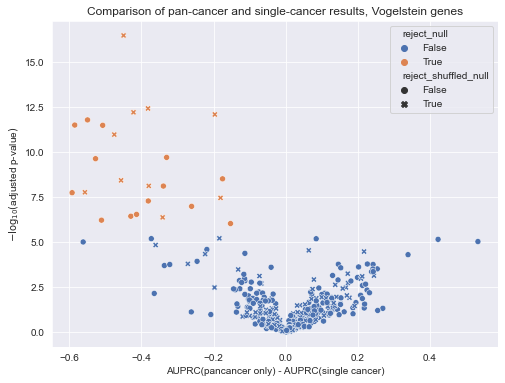

In [9]:
sc_experiment_sig_df['nlog10_p'] = -np.log(sc_experiment_sig_df.p_value)

sns.set({'figure.figsize': (8, 6)})
sns.scatterplot(data=sc_experiment_sig_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                style='reject_shuffled_null')
plt.xlabel('AUPRC(pancancer only) - AUPRC(single cancer)')
plt.ylabel(r'$-\log_{10}($adjusted p-value$)$')
plt.title('Comparison of pan-cancer and single-cancer results, Vogelstein genes')

In [ ]:
experiment_comparison_df = au.compare_results(pancancer_df,
                                              pancancer_df=remove_cancer_df,
                                              identifier='identifier',
                                              metric='aupr',
                                              correction=True,
                                              verbose=False)
experiment_comparison_df.sort_values(by='p_value').head()

In [ ]:
results_dir = '/home/jake/data/pancancer_vogelstein_09_25'
pancancer_comparison_df = pd.read_csv(os.path.join(results_dir, 'pancancer_pvals.tsv'),
                                      index_col=False, sep='\t')
overlap = experiment_comparison_df.index.intersection(pancancer_comparison_df.index)
experiment_sig_df = (
    experiment_comparison_df.reindex(overlap)
                            .assign(reject_shuffled_null=pancancer_comparison_df.reject_null)
)
experiment_sig_df.sort_values(by='p_value').head(n=15)

In [ ]:
experiment_sig_df['nlog10_p'] = -np.log(experiment_sig_df.p_value)

sns.set({'figure.figsize': (8, 6)})
sns.scatterplot(data=experiment_sig_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                style='reject_shuffled_null')
plt.xlabel('AUPRC(pancancer only) - AUPRC(pancancer)')
plt.ylabel(r'$-\log_{10}($adjusted p-value$)$')
plt.title('Comparison of "pan-cancer only" and pan-cancer results, Vogelstein genes')

In [ ]:
plot_identifier = 'BRAF_THCA'
# plot_identifier = 'BRAF_SKCM'
# plot_identifier = 'NF1_GBM'

results_df = pd.concat((
    single_cancer_df, pancancer_df, remove_cancer_df
))
plot_df = results_df[
    (results_df.identifier == plot_identifier) &
    (results_df.data_type == 'test')
].sort_values(by=['signal', 'train_set'])

sns.set({'figure.figsize': (14, 5)})
fig, axarr = plt.subplots(1, 2)
sns.boxplot(data=plot_df, x='train_set', y='aupr', hue='signal', ax=axarr[0])
sns.scatterplot(data=experiment_sig_df, x='delta_mean', y='nlog10_p',
                alpha=0.3, ax=axarr[1])

def highlight_id(x, y, val, ax, id_to_plot):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if point['val'] == id_to_plot:
            ax.scatter(point['x'], point['y'], color='red', marker='+', s=100)
        
highlight_id(experiment_sig_df.delta_mean, experiment_sig_df.nlog10_p,
             experiment_sig_df.identifier, axarr[1], plot_identifier)

axarr[0].set_title('{} performance for varying train sets'.format(plot_identifier))
axarr[1].set_title('Highlight {} in comparison plot'.format(plot_identifier))